1. Download data for a week from https://data.stadt-zuerich.ch/dataset/vbz-fahrzeiten-ogd as csv. The files `Haltestelle.csv` and `Haltepunkt.csv` are needed too.
2. Since there are about 1.3 million rows in one file, we take a smaller subset from it to work with. Use `head -n 10000 fahrzeitensollist2017070220170708.csv > small.csv` (adjust the filename) to create the subset in `small.csv`.

In [3]:
%matplotlib inline
import numpy

from datetime import datetime

import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

# Not necessary, but I like the ggplot style better
plt.style.use('ggplot') 

# Read csv to dataframe
df = pd.read_csv('small.csv')

First let's create a simple histogram of how late or early the public transport was during the given time period. For that we will calculate the time differences between target and actual time. 

Then let's compare to a normal distribution for the mean and standard deviation of the time differences.

[-250, 250, 0, 0.012]

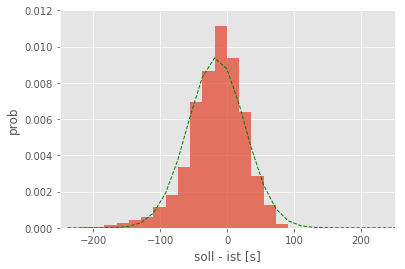

In [6]:
diffs = []
for index, row in df.iterrows():
    # Here the delay is calculated
    diff = row['soll_an_von'] - row['ist_an_von']
    diffs.append(diff)

# Calculate mean and std
mu = numpy.mean(diffs)
sigma = numpy.std(diffs)

n, bins, patches = plt.hist(diffs, 50, alpha=0.75, normed=1)

# Add normal distribution ("best fit")
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'g--', linewidth=1)

plt.xlabel('soll - ist [s]')
plt.ylabel('prob')
plt.grid(True)

# Adjust axis because of outliers
plt.axis([-250, 250, 0, 0.012])

Now let's create a timeline to see, if the delays differ depending on time.

The times will be rounded to the hour.

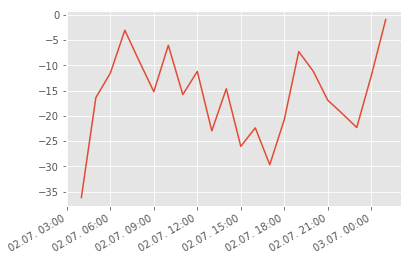

In [16]:
def makeDatetime(date, seconds):
    """Returns datetime object rounded to the hour.
    
    date: date in format dd.mm.yy
    seconds: seconds of the day (int, from 0 to 86400)
    """
    hour = int(seconds / 3600) # same as numpy.floor()
    minute = (seconds - hour * 3600) / 60

    dt_obj = datetime.strptime(date, '%d.%m.%y')
    dt_obj = dt_obj.replace(hour=hour)

    return dt_obj

# Save differences in here as dt_obj -> [diffs]
tod_dict = {}
for index, row in df.iterrows():
    dt_obj = makeDatetime(row['datum_von'], row['soll_an_von']) # time from "soll"
    diff = row['soll_an_von'] - row['ist_an_von']

    if dt_obj not in tod_dict: tod_dict[dt_obj] = []
    tod_dict[dt_obj].append(diff)
    
# Calculate average of every hour
# Sort by time
tod_times = [] # x
tod_avgs = [] # y
for dt_obj in sorted(tod_dict):
    dt_diffs = tod_dict[dt_obj]

    tod_times.append(dt_obj)
    tod_avgs.append(numpy.mean(dt_diffs))

# Plot
fig, ax = plt.subplots(1)
fig.autofmt_xdate()

plt.plot(tod_times, tod_avgs)

xfmt = mdates.DateFormatter('%d.%m. %H:%M')
ax.xaxis.set_major_formatter(xfmt)